In [44]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt

/tmp/ipykernel_2804/4132813225.py:8: RuntimeWarning: divide by zero encountered in divide
  y1 = np.exp(1 / x)


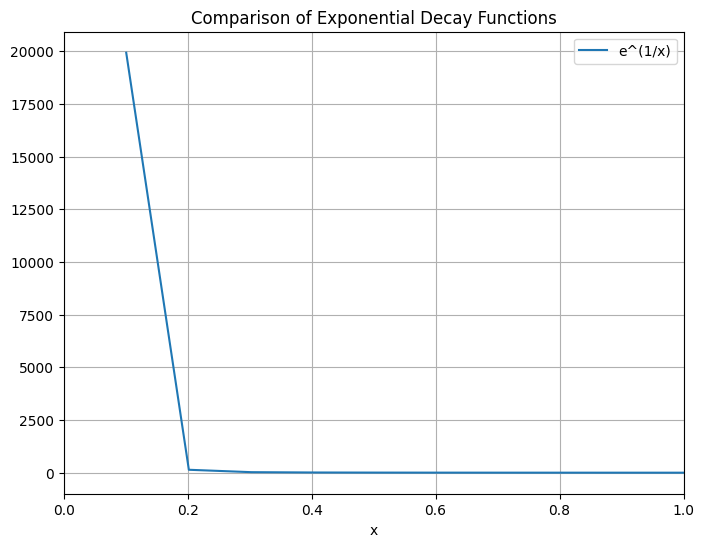

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# x 값 범위 설정
x = np.linspace(0, 10, 100)

# 두 함수 정의
y1 = np.exp(1 / x)
# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label='e^(1/x)')
plt.xlabel('x')
plt.title('Comparison of Exponential Decay Functions')
plt.legend()
plt.grid(True)
plt.xlim((0,1))
plt.show()


In [46]:
def random_x_encode(min_x, max_x, len_bit):
    # 주어진 범위에서 실수 하나를 무작위로 선택
    x = np.random.uniform(min_x, max_x)
    print('Selected x : ',x)
    # 실수를 소수점 아래 4자리까지 고려하여 정수로 변환
    scaled_x = int(x * 10000)  # x를 10000배 하여 소수점 아래를 정수로 만듦

    # 정수를 이진수 문자열로 변환
    binary_str = bin(abs(scaled_x))[2:]  # 이진수로 변환하고, '0b' 접두사 제거

    # 음수일 경우를 위한 2의 보수 처리 (선택적)
    if x < 0:
        binary_str = bin((1 << len_bit) - int(binary_str, 2) - 1)[2:].zfill(len_bit)

    # 필요한 경우 앞을 '0'으로 채워 비트 길이를 맞춤
    binary_str_padded = binary_str.zfill(len_bit)

    # 이진수 문자열을 numpy 배열로 변환
    binary_array = np.array(list(binary_str_padded), dtype=int)
    return binary_array

In [47]:
def decode_x(binary_array):
    # numpy 배열을 문자열로 변환
    binary_str = ''.join(binary_array.astype(str))
    
    # 최상위 비트가 1이면 음수, 0이면 양수
    if binary_str[0] == '1':
        # 2의 보수를 취하여 음수값 계산
        # 모든 비트를 반전시킨 후, 1을 더함
        inverse_binary_str = ''.join('1' if x == '0' else '0' for x in binary_str)
        decimal = -(int(inverse_binary_str, 2))  
    else:
        # 양수일 경우 직접 10진수로 변환
        decimal = int(binary_str, 2)
    
    decimal = round(decimal*(10**-4),4)
    return decimal

In [48]:
k = decode_x(y)
k

6.0

In [49]:
# x1 범위, 비트수
min_x1 = -3.1
max_x1 = 12.1
len_bit_x1 = 18

# x2 범위, 비트수
min_x2 = 4.1
max_x2 = 5.8
len_bit_x2 = 17


In [50]:
def near_binary(binary_array):
    # 배열의 복사본을 생성
    modified_array = binary_array.copy()
    
    n = len(modified_array)
    idx1, idx2 = np.random.choice(n, size=2, replace=False)
    
    # 복사본에 대해 변경을 적용
    modified_array[idx1] = 1 - modified_array[idx1]
    modified_array[idx2] = 1 - modified_array[idx2]
    
    # 변경된 복사본을 리턴
    return modified_array

In [51]:
test_some = random_x_encode(min_x1,max_x1,len_bit_x1)
print(test_some)
test_str = near_binary(test_some)
print(test_str)
print(test_some)

Selected x :  8.520074251647037
[0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0]
[1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0]
[0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0]


In [52]:
# 목적 함수 정의
def objective_func(x1, x2):        
    return 21.5 + x1 * np.sin(4 * np.pi * x1) + x2 * np.sin(20 * np.pi * x2)

In [53]:
def is_out(binary_num, min_num, max_num):
    num = decode_x(binary_num)
    if num >= min_num and num <= max_num:
        return False
    else:
        return True

In [54]:
# 델타(초기해-이웃해)에 따른 알고리즘
def deal_delta(early_sol, late_sol, Tk , near_x1_binary, near_x2_binary):
    delta = early_sol - late_sol

    # 탈출확률
    second_chance = math.exp(-delta/Tk)
    ran_01 = random.uniform(0, 1)

    if is_out(near_x1_binary,min_x1,max_x1):
        second_chance=0.0
        delta = 1
    
    if is_out(near_x2_binary,min_x2,max_x2):
        second_chance=0.0
        delta = 1

    if delta <= 0:
        #print('passed')
        return late_sol
    else:
        if second_chance > ran_01:
            print(f'early_sol : {early_sol}, late_sol : {late_sol}, delta : {delta}, second_chance : {second_chance}, ran01 : {ran_01}')
            return late_sol
        else:
            return early_sol

In [55]:
test_q = random.uniform(0, 1)
test_q

0.6233105560328933

In [56]:
# 인접값,해 생성

def near_x(x1_binary,x2_binary):
    # 인접값 생성
    near_x1_binary = near_binary(x1_binary)
    near_x2_binary = near_binary(x2_binary)
    
    # 인접해 생성
    dec_flip_x1 = decode_x(near_x1_binary)
    dec_flip_x2 = decode_x(near_x2_binary)
    near_sol = objective_func(dec_flip_x1,dec_flip_x2)

    return near_sol, near_x1_binary, near_x2_binary

In [57]:
# 최종 알고리즘
def Simulated_Annealing(x1_binary, x2_binary,inner_times, Tk):

    # 완전초기해 생성
    dec_x1 = decode_x(x1_binary)
    dec_x2 = decode_x(x2_binary)
    first_sol = objective_func(dec_x1,dec_x2)

    times = 0
    success_list = []

    while( times<=inner_times ):
        near_sol, near_x1_binary, near_x2_binary = near_x(x1_binary, x2_binary)
        
        is_better = deal_delta(first_sol,near_sol,Tk, near_x1_binary, near_x2_binary)

        if is_better == near_sol:
            first_sol = near_sol
            x1_binary = near_x1_binary.copy()
            x2_binary = near_x2_binary.copy()
            success_list.append((x1_binary,x2_binary))
            times+=1
        else:
            times+=1

    return success_list

In [58]:
# 완전초기값 생성
x1_binary = random_x_encode(min_x1,max_x1,len_bit_x1)
x2_binary = random_x_encode(min_x2,max_x2,len_bit_x2)

flag_x1_binary = x1_binary
flag_x2_binary = x2_binary

Selected x :  8.48439025837129
Selected x :  5.671426123886677


In [59]:
# 쿨링 스케줄
def calculate_Tk(alpha=0.90, k_range=20, initial_value=1):
    T = [initial_value]
    for k in range(1, k_range):
        T_rounded = round(alpha * T[k-1], 2) 
        T.append(T_rounded)
        
    return T

Tk_list = calculate_Tk()


In [60]:
# SA실행
Final_list = []
inner_times = 10000
for Tk in Tk_list:
    
    tmp_list = Simulated_Annealing(flag_x1_binary,flag_x2_binary,inner_times,Tk)
    Final_list.append(tmp_list)
    
    flag_x1_binary = tmp_list[-1][0]
    flag_x2_binary = tmp_list[-1][1]

    print(decode_x(tmp_list[-1][0]), decode_x(tmp_list[-1][1]))


early_sol : 31.722171137281258, late_sol : 30.893200240587948, delta : 0.8289708966933098, second_chance : 0.4364982570629826, ran01 : 0.30697433949941666
early_sol : 33.064160294942546, late_sol : 32.954842040925584, delta : 0.10931825401696216, second_chance : 0.896445074848865, ran01 : 0.6065599291451065
early_sol : 34.810889674036616, late_sol : 34.576925829534495, delta : 0.23396384450212082, second_chance : 0.7913904284932883, ran01 : 0.10118396217710235
early_sol : 34.8440322435295, late_sol : 33.992293048083944, delta : 0.8517391954455533, second_chance : 0.42667221989364473, ran01 : 0.18937948736338006
early_sol : 33.992293048083944, late_sol : 31.70215277973041, delta : 2.2901402683535323, second_chance : 0.10125225837018403, ran01 : 0.07201312987150099
early_sol : 34.44797579651692, late_sol : 34.2835643017556, delta : 0.16441149476132466, second_chance : 0.8483928408325001, ran01 : 0.3939478577242206
early_sol : 34.2835643017556, late_sol : 34.283265746259836, delta : 0.000

early_sol : 36.185698882815394, late_sol : 35.6955495996282, delta : 0.4901492831871934, second_chance : 0.6125349461897273, ran01 : 0.24385024267415245
early_sol : 35.6955495996282, late_sol : 35.54745262523406, delta : 0.14809697439414293, second_chance : 0.8623474852622183, ran01 : 0.7200831264778473
early_sol : 36.41847710487634, late_sol : 36.39525727520675, delta : 0.02321982966958558, second_chance : 0.9770476760957862, ran01 : 0.7524006732045485
early_sol : 36.39525727520675, late_sol : 36.00913610164931, delta : 0.38612117355744147, second_chance : 0.6796881604578248, ran01 : 0.18276156555203915
early_sol : 36.039553936216336, late_sol : 35.515261681597245, delta : 0.5242922546190911, second_chance : 0.5919741831345394, ran01 : 0.5514545849599523
early_sol : 35.63718221289191, late_sol : 34.8115677685332, delta : 0.8256144443587061, second_chance : 0.43796580415512987, ran01 : 0.2519884473144077
early_sol : 34.8115677685332, late_sol : 34.67523470407299, delta : 0.136333064460

In [61]:
#시각화 작업
x1_list = []
x2_list = []
plot_list = []

for i in Final_list:
    for j in i:
        dec_x1 = decode_x(j[0])
        dec_x2 = decode_x(j[1])
        x1_list.append(dec_x1)
        x2_list.append(dec_x2)
        plot_list.append(objective_func(dec_x1,dec_x2))

In [62]:
#평균치
x1_mean = sum(x1_list) / len(x1_list)
x2_mean = sum(x2_list) / len(x2_list)
Y_mean = sum(plot_list) / len(plot_list)

print(x1_mean, x2_mean, Y_mean)

11.371205576604254 5.3631600047360335 37.554418361264474


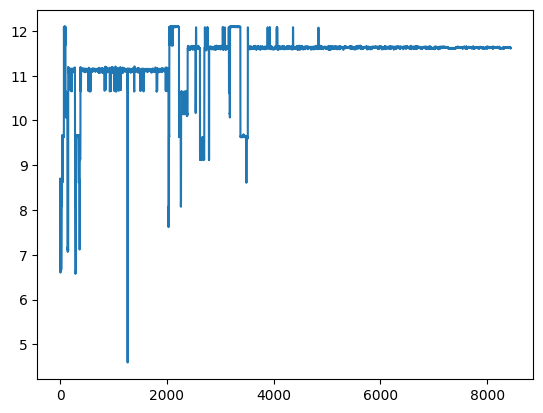

In [63]:
plt.plot(x1_list)

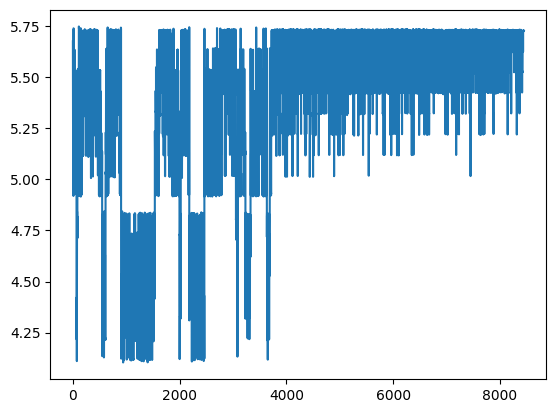

In [64]:
plt.plot(x2_list)

In [65]:
x2_list[-1]

5.7266

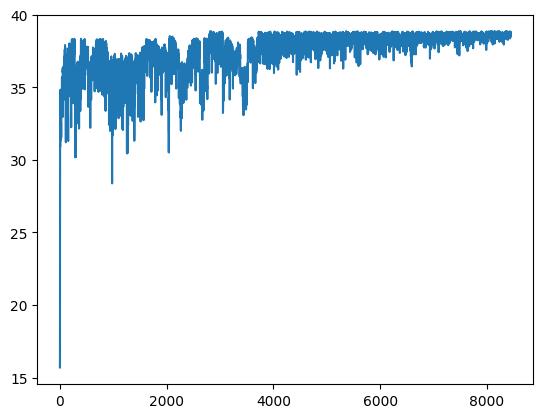

In [66]:
plt.plot(plot_list)

In [67]:
plot_list[-1]

38.80400866656365